<a href="https://colab.research.google.com/github/mrzhuzhe/pepper/blob/master/RL/Connect_4_Deep_Reinforcement_Learning_introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning to play connect 4 using minimax Deep Q-learning
In this notebook we will train a reinforcement learning (RL) agent using minimax deep Q-learning on a classic game: Connect 4. 

In Connect 4, your objective is to get 4 of your checkers in a row horizontally, vertically, or diagonally on the game board before your opponent. When it's your turn, you “drop” one of your checkers into one of the columns at the top of the board. Then, let your opponent take their turn. This means each move may be trying to either win for you, or trying to stop your opponent from winning.

See the [Kaggle competition](https://www.kaggle.com/c/connectx) for more background and the [thread](https://www.kaggle.com/c/connectx/discussion/129145) that discusses this notebook. This [high level presentation](https://docs.google.com/presentation/d/1bNwOMZq1_poMRm6zPEFtEuCTSYd5u8OD9HbM4X6PsuI/edit?usp=sharing) on using RL in board games may also be useful. I adapted code from some of the public notebooks but developed all of the RL logic myself.

![alt text](https://storage.googleapis.com/kaggle-media/competitions/ConnectX/Walter's%20image.png)

Last modified on Feb 10th 2020 (Tom Van de Wiele)

# 成功的snapshot
https://colab.research.google.com/drive/1igIrGSmr30FuWfJ-nMmCmIwgthT6AvqI#scrollTo=ApMTvY6bpdmT

## Install dependencies


In [1]:
!pip install 'kaggle-environments>=0.1.6'
!pip install 'recordtype'

     |████████████████████████████████| 1.2 MB 9.1 MB/s 
     |████████████████████████████████| 69 kB 6.7 MB/s 
  Attempting uninstall: jsonschema
    Found existing installation: jsonschema 2.6.0
    Uninstalling jsonschema-2.6.0:
      Successfully uninstalled jsonschema-2.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbclient 0.5.4 requires jupyter-client>=6.1.5, but you have jupyter-client 5.3.5 which is incompatible.


## Google Colab keyboard shortcuts

*   Create a new cell : (CTRL + m) + a
*   Delete a new cell : (CTRL + m) + d
*   Execute cell and move on to the next one: CTRL + ENTER
*   Toggle the contents of cells under a title: CTRL + #

## Some Colab tips
Double click on the white input fields to toggle between hiding and showing the code.  Try it out on this cell, it also works for text cells!

You can use the arrows on the left to toggle between hiding and showing the code for one/multiple cells (equivalent to CTRL + #).


## Imports

In [3]:
#@title Imports
import numpy as np
import pandas as pd
%tensorflow_version 1.x # See https://colab.research.google.com/notebooks/tensorflow_version.ipynb
import tensorflow as tf
import time

from IPython.display import clear_output
from IPython.display import display
from IPython.display import Image
from kaggle_environments import evaluate as evaluate_game
from kaggle_environments import make as make_game
from kaggle_environments import utils as utils_game
from random import choice
from recordtype import recordtype
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # See https://colab.research.google.com/notebooks/tensorflow_version.ipynb`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
Loading environment football failed: No module named 'gfootball'


## Utility functions


In [4]:
#@title Various utilities

ExperienceStep = recordtype('ExperienceStep', [
  'game_id',
  'current_network_input',
  'action',
  'next_network_input',
  'last_episode_action',
  'episode_reward',
  ])

# Collect user input - Modified from https://www.kaggle.com/marcovasquez/how-to-play-with-computer-and-check-winner
def get_input(user, observation, configuration):
  ncol = configuration.columns
  time.sleep(0.1)
  input1 = 'Input from player {}: '.format(your_name)
  while True:
    try:
      print('Enter Value from 1 to 7')
      raw_input = input(input1)
      user_input = int(raw_input)
    except ValueError:
      try:
        print('Invalid input:', user_input)
        continue
      except UnboundLocalError:
        user_input = -1
        if raw_input == 'q':
          break
        continue
    np_board = obs_to_board(observation, configuration)
    valid_actions = np.where(np_board[0] == 0)[0]
    if user_input <= 0 or user_input > ncol or (
        user_input-1) not in valid_actions:
      print('invalid input:', user_input)
      print('Valid actions: {}'.format(valid_actions+1))
    else:
      return user_input-1


# Convert the 1D observation list to a 2D numpy array
def obs_to_board(observation, configuration):
  return np.array(observation.board).reshape(
    configuration.rows, configuration.columns)
  

def check_winner(observation):
  '''
  Source: https://www.kaggle.com/marcovasquez/how-to-play-with-computer-and-check-winner
  This function returns the value of the winner.
  
  INPUT:  observation 
  OUTPUT: 1 for user Winner or 2 for Computer Winner 
  '''
  line1 = observation.board[0:7] # bottom row
  line2 = observation.board[7:14]
  line3 = observation.board[14:21]
  line4 = observation.board[21:28]
  line5 = observation.board[28:35]
  line6 = observation.board[35:42]

  board = [line1, line2 , line3, line4, line5, line6] 

  # Check rows for winner
  for row in range(6):
    for col in range(4):
      if (board[row][col] == board[row][col + 1] == board[row][col + 2] == (
        board[row][col + 3])) and (board[row][col] != 0):
        return board[row][col]  #Return Number that match row

  # Check columns for winner
  for col in range(7):
    for row in range(3):
      if (board[row][col] == board[row + 1][col] == board[row + 2][col] == (
        board[row + 3][col])) and (board[row][col] != 0):
        return board[row][col]  #Return Number that match column

  # Check diagonal (top-left to bottom-right) for winner
  for row in range(3):
    for col in range(4):
      if (board[row][col] == board[row + 1][col + 1] == board[
          row + 2][col + 2] ==\
        board[row + 3][col + 3]) and (board[row][col] != 0):
        return board[row][col] #Return Number that match diagonal


  # Check diagonal (bottom-left to top-right) for winner
  for row in range(5, 2, -1):
    for col in range(4):
      if (board[row][col] == board[row - 1][col + 1] == (
          board[row - 2][col + 2]) == board[row - 3][col + 3]) and (
            board[row][col] != 0):
        return board[row][col] #Return Number that match diagonal

  # No winner: return None
  return None


# Custom class to reuse data of subsequent interations with the environment
# FIFO buffer. Experience buffer (also referred to as the replay buffer).
class ExperienceBuffer:
  def __init__(self, buffer_size):
    self.buffer_size = buffer_size
    self.episode_offset = 0
    self.data = []
    self.episode_ids = np.array([])
    
  def add(self, data):
    episode_ids = np.array([d.game_id for d in data])
    num_episodes = episode_ids[-1] + 1
    if num_episodes > self.buffer_size:
      # Keep most recent experience of the experience batch
      data = data[
        np.where(episode_ids == (num_episodes-self.buffer_size))[0][0]:]
      self.data = data
      self.episode_ids = episode_ids
      self.episode_offset = 0
      return
      
    episode_ids = episode_ids + self.episode_offset
    self.data = data + self.data
    self.episode_ids = np.concatenate([episode_ids, self.episode_ids])
    
    unique_episode_ids = pd.unique(self.episode_ids)
    if unique_episode_ids.size > self.buffer_size:
      cutoff_index = np.where(self.episode_ids == unique_episode_ids[
        self.buffer_size])[0][0]
      self.data = self.data[:cutoff_index]
      self.episode_ids = self.episode_ids[:cutoff_index]
    self.episode_offset += num_episodes
    
  def get_all_data(self):
    return self.data

  def size(self):
    return len(self.data)

  def num_episodes(self):
    return np.unique(self.episode_ids).size

## Let's play against a random agent to try out the game - q to exit the game

In [5]:
your_name = 'Tom' #@param {type:"string"}
play_against_random = False #@param ["False", "True"] {type:"raw"}
plot_resolution = 400 #@param {type:"slider", min:200, max:500, step:1}
# Here we define an agent that picks a random non-empty column
def my_random_agent(observation, configuration):
  return int(choice([c for c in range(
      configuration.columns) if observation.board[c] == 0]))
    
def play_against_agent(opponent_agent):
  # Play as first position against the opposing agent.
  # modified from https://www.kaggle.com/marcovasquez/how-to-play-with-computer-and-check-winner
  env = make_game("connectx", debug=False, configuration={"timeout": 10})
  trainer = env.train([None, opponent_agent])
  observation = trainer.reset()

  while not env.done:
    clear_output(wait=True) # Comment if you want to keep track of every action
    print("{}'s color: Blue".format(your_name))
    env.render(mode="ipython", width=plot_resolution, height=plot_resolution,
              header=False, controls=False)

    my_action = get_input(your_name, observation, env.configuration)
    if my_action is None:
      print("Exiting game after pressing q")
      return

    observation, reward, done, info = trainer.step(my_action)
    #print(observation, reward, done, info)
    if (check_winner(observation) == 1):
      print("You Won, Amazing! \nGAME OVER")
        
    elif (check_winner(observation) == 2):
      print("The opponent Won! \nGAME OVER")

  if (check_winner(observation) is None):
    print("That is a draw between you and the opponent")

  env.render(mode="ipython", width=plot_resolution, height=plot_resolution,
            header=False, controls=False)
  
if play_against_random:
  play_against_agent(my_random_agent)

## That was too easy, we should obviously train a deep reinforcement learning agent to play against.

In this tutorial we will be using Q-learning to train an agent. [How does Q-learning work?](https://https://en.wikipedia.org/wiki/Q-learning) The Q-values represent the expected terminal reward when taking action **a** in board state **s**. A win is associated with a terminal reward of 1, a loss with a 0 reward and a draw with a 0.5 reward. The learning process looks as follows:

Randomly initialize Q(s) - a mapping from the current board state to the Q-values of all actions for the current state. 

While True:

    1.   Play a fixed number of games using self-play and add the experience to the experience buffer
    2.   Update the Q network using the experience from the experience buffer
    3.   Evaluate the trained agent against a random agent to find out if we are making progress 

  
Attention! This notebook intentionally introduced 2 obvious bugs and one configuration setting that is obviously suboptimal. The bugs and their fixes are listed at the bottom of the notebook but please try to find and fix them yourself first!

In [6]:
#@title Define possible network architectures of the Q-network
# Basic MLP Connect 4 network
def mlp_connect4(config):
  inputs = Input((6, 7, 3), name='encoded_board')
  x = inputs
  
  # Flatten the input
  x = Flatten()(x)
  
  # MLP layers - sigmoid activation on the final layer
  for i, layer_size in enumerate(config['mlp_layers']):
    x = Dense(layer_size, activation='linear')(x)
    if i < (len(config['mlp_layers'])-1):
      x = Activation('relu')(x)
    else:
      x = Activation('sigmoid', name='Q-values')(x)
    
  outputs = x
  
  return (inputs, outputs)

# Basic convolutional Connect 4 network
def convnet_connect4(config):
  inputs = Input((6, 7, 3), name='encoded_board')
  x = inputs
  
  # Convolutional layers
  conv_outputs = []
  for i, (filters, kernel, strides) in enumerate(
      config['filters_kernels_strides']):
    x = Conv2D(filters=filters, kernel_size=kernel, strides=strides,
               padding='same', activation='linear')(x)
    x = Activation('relu')(x)
    
  # Flatten the activations
  x = Flatten()(x)
  
  # MLP layers - sigmoid activation on the final layer
  for i, layer_size in enumerate(config['mlp_layers']):   
    x = Dense(layer_size, activation='linear')(x)   
    if i < (len(config['mlp_layers'])-1):
      x = Activation('relu')(x)
    else:
      # Head of the network
      outputs = Activation('sigmoid', name='Q-values')(x)
  
  return (inputs, outputs)

In [62]:
#@title Network evaluation and action selection

# Convert the raw observation to the network input - this is the place to add
# engineered features
def obs_to_network_input(observation, configuration, player_id):
  board = np.array(observation['board']).reshape(
    configuration.rows, configuration.columns)
  
  # One hot encoding of the inputs (empty, player 1, player 2)
  obs_input = (np.arange(3) == board[..., None]).astype(float)
  
  # Swap player 1 and player 2 positions? The network always assumes that 'my'
  # stones (player_id) come first
  if player_id == 1:
    tmp = obs_input[:, :, 1].copy()
    obs_input[:, :, 1] = obs_input[:, :, 2]
    obs_input[:, :, 2] = tmp
  
  return obs_input


# Predict network outputs where the number of inputs can be large. Use batching
# when there are more inputs than the max_batch_size
def my_keras_predict(model, inputs, max_batch_size=10000):
  num_inputs = inputs.shape[0]
  num_batches = int(np.ceil(num_inputs/max_batch_size))
  
  outputs = []
  for i in range(num_batches):
    end_id = num_inputs if i == (num_batches-1) else (i+1)*max_batch_size
    batch_inputs = inputs[i*max_batch_size:end_id]
    if tf.__version__[0] == '2':
      batch_outputs = model(batch_inputs)
      batch_outputs = batch_outputs.numpy()
    else:
      batch_outputs = model.predict(batch_inputs)
    outputs.append(batch_outputs)

  return np.concatenate([o for o in outputs])

def select_action_from_q(q_values, valid_actions, epsilon_greedy_parameter): 
  # Select the best valid or a valid exploratory action using epsilon-greedy
  best_q = q_values[valid_actions].max()
  best_a_ids = np.where(q_values[valid_actions] == best_q)[0]
  best_a = valid_actions[np.random.choice(best_a_ids)]
  exploratory_a = np.random.choice(valid_actions)
  explore = np.random.uniform() < epsilon_greedy_parameter
  action = exploratory_a if explore else best_a
    
  return action


def get_agent_q_and_a(agent, board, epsilon_greedy_parameter):  
  # Obtain the Q-values
  q_values = my_keras_predict(agent, np.expand_dims(board, 0))[0]
  
  # Select an action from the Q-values
  valid_actions = np.where(board[0, :, 0] == 1)[0]
  action = select_action_from_q(q_values, valid_actions,
                                epsilon_greedy_parameter)
  
  return q_values, action

In [63]:
#@title Self play
def self_play(agent, num_games, verbose, epsilon_greedy_parameter):
  experience = []
  for game_id in range(num_games):
    this_game_data = []
    env = make_game('connectx')
    env.reset()
    episode_step = 0
    
    # Take actions until the game is terminated
    while not env.done:
      if env.state[0].status == 'ACTIVE':
        player_id = 0
      elif env.state[1].status == 'ACTIVE':
        player_id = 1
      #print(env.state[player_id].observation)

      #if not hasattr(env.state[player_id].observation, 'board'):
      #  continue
      #print(env.state)
      # Obtain the Q-values and selected action for the current state
      current_network_input = obs_to_network_input(
          env.state[0].observation, env.configuration, player_id)
      q_values, action = get_agent_q_and_a(
        agent, current_network_input, epsilon_greedy_parameter)
      
      if episode_step == 0 and game_id == 0:
        print("Start move Q-values: {}".format(np.around(q_values, 3)))

      env.step([int(action) if i == player_id else None for i in [0, 1]])

      # Store the state transition data - swap the player id!
      next_network_input = obs_to_network_input(
          env.state[0].observation, env.configuration, 1-player_id)
      this_game_data.append(ExperienceStep(
        game_id,
        current_network_input,
        action,
        next_network_input,
        False, # Last episode action, overwritten at the end of the episode
        np.nan, # Terminal reward, overwritten at the end of the episode
        ))
      episode_step += 1
      
    # Overwrite the terminal reward for all actions
    first_terminal_reward = env.state[0].reward
    for i in range(len(this_game_data)):
      if i % 2 == 0:
        this_game_data[i].episode_reward = first_terminal_reward
      else:
        this_game_data[i].episode_reward = 1-first_terminal_reward
    
    # Update statistics which can not be computed before the episode is over.
    this_game_data[-1].last_episode_action = True # Last episode action
    
    experience.extend(this_game_data)

    if verbose and game_id % 10 == 9:
      print('Completed playing game {} of {}'.format(game_id+1, num_games))

  return experience

In [65]:
#@title One step minimax Q-learning target computation - Source of name: https://arxiv.org/pdf/1901.00137.pdf. To be more precise, we actually use negamax Q-learning since we rely on the property that the game is a two-player zero sum game.
def one_step_minimax_q_targets(next_q_vals, experience):
  next_q_minimax_star = (1-next_q_vals.max(1)).tolist() # Negamax - 2 player 0-sum
  terminal_rewards = [e.episode_reward for e in experience]
  last_episode_actions = [e.last_episode_action for e in experience]
  #target_qs = next_q_minimax_star
  target_qs = np.array([t if l else n for(t, l, n) in zip(
    terminal_rewards, last_episode_actions, next_q_minimax_star)])
  
  return target_qs


# N-step minimax Q-learning target computation
def minimax_q_n_step_targets(this_q_vals, next_q_vals, experience,
                          return_steps_trace):
  # Collect generic experience values of interest
  return_steps, lambda_ = return_steps_trace
  actions = [e.action for e in experience]
  terminal_actions = np.concatenate(
    [np.array([e.last_episode_action for e in experience]),
     np.zeros((return_steps), dtype=np.bool)])
  terminal_rewards = 1-np.array([e.episode_reward for e in experience])
  num_experience_steps = len(experience)
  
  # Determine if the actions are exploratory or greedy
  greedy_actions = np.zeros((num_experience_steps+return_steps),
                            dtype=np.bool)
  for i in range(num_experience_steps):
    valid_actions = np.where(experience[i].current_network_input[:, :, 0].sum(
        0) > 0)[0]
    best_valid_q = this_q_vals[i][valid_actions].max()
    greedy_actions[i] = best_valid_q == this_q_vals[i, actions[i]]
  
  # Extend and overwrite next q vals to include the true rewards
  next_q_vals = np.concatenate([next_q_vals, -999*np.ones((
    return_steps, next_q_vals.shape[1]))])
  next_q_vals[terminal_actions] = np.tile(
    np.expand_dims(terminal_rewards[terminal_actions[
      :num_experience_steps]], -1), [1, next_q_vals.shape[1]])
  
  # Consider returns, up to 'return_steps' into the future. The trace is cut
  # at episode boundaries and before considering a non-exploratory action
  consider_targets = np.ones((num_experience_steps), dtype=np.bool)
  target_lambda_sums = np.zeros((num_experience_steps))
  target_weighted_sums = np.zeros((num_experience_steps))
  trace_multiplier = 1
  for i in range(return_steps):
    best_qs = next_q_vals[i:(i+num_experience_steps)].max(-1)
    if i % 2 == 0:
      best_qs = 1-best_qs
    target_weighted_sums[consider_targets] += trace_multiplier*best_qs[
      consider_targets]
    target_lambda_sums[consider_targets] += trace_multiplier
      
    # Don't consider any further targets if this was the episode terminal
    # action
    consider_targets = np.logical_and(
        consider_targets, np.logical_not(
          terminal_actions[i:(i+num_experience_steps)]))
    
    # Don't consider the target if the next action is exploratory
    # Extending greedy actions with return_steps False values makes sure
    # we don't consider N step returns where there is no data
    consider_targets = np.logical_and(
      consider_targets, greedy_actions[(i+1):(i+1+num_experience_steps)])
    trace_multiplier *= lambda_
    
  targets = target_weighted_sums/target_lambda_sums
  
  return targets


# Get the q-learning observations and targets
def minimax_q_learning(model, experience, nan_coding_value, return_steps_trace):
  # Evaluate the Q-values of the current and next state for all observations
  num_actions = experience[0].current_network_input.shape[1]
  num_steps = len(experience)
  this_states = np.stack([e.current_network_input for e in experience])
  next_states = np.stack([e.next_network_input for e in experience])
  this_q_vals = my_keras_predict(model, this_states)
  next_q_vals = my_keras_predict(model, next_states)
    
  # Filter out next Q-values where the next action is not valid. Filtered out
  # since every target computation performs a max operation.
  # This was an unintended bug in the original version of the notebook!
  next_q_vals[next_states[:, 0, :, 0] == 0] = -1

  # Compute the target Q-values
  num_return_steps = return_steps_trace[0]
  if num_return_steps == 1:
    target_qs = one_step_minimax_q_targets(next_q_vals, experience)
  else:
    target_qs = minimax_q_n_step_targets(this_q_vals, next_q_vals, experience,
                                      return_steps_trace)
  
  # Don't learn about non acted Q-values
  all_target_qs = nan_coding_value*np.ones([num_steps, num_actions])
    
  # Set the targets for the actions that were selected
  actions = [e.action for e in experience]
  all_target_qs[np.arange(num_steps), actions] = target_qs
    
  return this_states, all_target_qs


# Masked mse loss - values equal to mask_val are ignored in the loss
def masked_mse(y, p, mask_val):
  mask = K.cast(K.not_equal(y, mask_val), K.floatx())
  if tf.__version__[0] == '2':
    masked_loss = tf.losses.mse(y*mask, p*mask)
  else:
    mask = K.cast(mask, 'float32')
    masked_loss = K.mean(tf.math.square(p*mask - y*mask), axis=-1)
    # masked_loss = tf.compat.v1.losses.mean_squared_error(y*mask, p*mask)
    
  return masked_loss
    
# Make the masked mse loss
def make_masked_mse(nan_coding_value):
  def loss(y, p):
    return masked_mse(y, p, mask_val=nan_coding_value)
  
  return loss


# Update the Q-network by minimzing the difference with the target q-values
def update_agent(experience, agent, config):
    nan_coding_value = config['nan_coding_value']
    return_steps_trace = config['return_steps_trace']
    x_train, y_train = minimax_q_learning(
      agent, experience, nan_coding_value, return_steps_trace)
    adam = Adam(lr=config['learning_rate'])
    agent.compile(optimizer=adam, loss=make_masked_mse(nan_coding_value))
    
    agent.fit(
      x_train,
      y_train,
      batch_size=config['batch_size'], 
      epochs=config['num_epochs'],
      verbose=config['verbose_fit']
      )

In [60]:
#@title Evaluate a greedy agent against the random agent
def eval_greedy_versus_random(agent, num_eval_games):
  rewards = []
  env = make_game('connectx', debug=False)
  my_agent_starts = False
  for i in range(num_eval_games):
    my_agent_starts = not my_agent_starts # Alternate start turns
    player_id = int(not my_agent_starts)

    episode_step = 0
    while not env.done:
      if env.state[0].status == 'ACTIVE':
        active = 0
      elif env.state[1].status == 'ACTIVE':
        active = 1

      current_network_input = obs_to_network_input(
          env.state[0].observation, env.configuration, player_id)
      if active == player_id:
        # Take the greedy action of the agent
        _, action = get_agent_q_and_a(
            agent, current_network_input, epsilon_greedy_parameter=0)
      else:
        # Take a random valid action
        valid_actions = np.where(current_network_input[0, :, 0] == 1)[0]
        action = np.random.choice(valid_actions)
      
      env.step([int(action) if i == active else None for i in [0, 1]])
      episode_step += 1

    rewards.append(env.state[player_id].reward)
    env.reset()

  return np.array(rewards).mean()

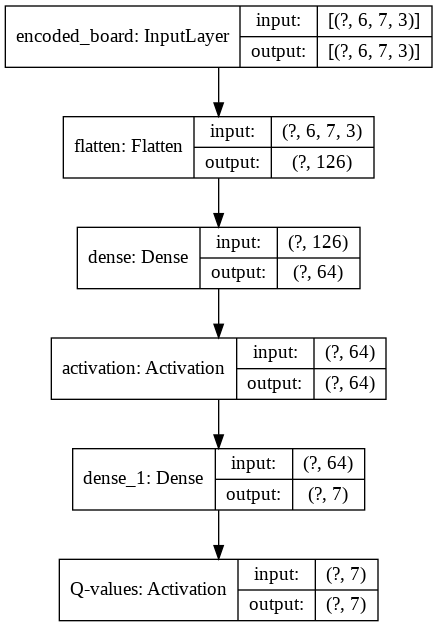

Start move Q-values: [0.435 0.398 0.457 0.326 0.391 0.457 0.371]
Experience buffer size: 30600 transitions (2000 episodes)
Mean reward against random agent in 50 games: 0.4

Start move Q-values: [0.451 0.274 0.483 0.312 0.291 0.46  0.374]
Experience buffer size: 29600 transitions (2000 episodes)
Mean reward against random agent in 50 games: 0.4

Start move Q-values: [0.46  0.196 0.489 0.229 0.36  0.431 0.399]
Experience buffer size: 27400 transitions (2000 episodes)
Mean reward against random agent in 50 games: 0.6

Start move Q-values: [0.404 0.271 0.577 0.161 0.422 0.424 0.359]
Experience buffer size: 28400 transitions (2000 episodes)
Mean reward against random agent in 50 games: 0.64

Start move Q-values: [0.335 0.324 0.442 0.123 0.317 0.39  0.486]
Experience buffer size: 31000 transitions (2000 episodes)
Mean reward against random agent in 50 games: 0.2

Start move Q-values: [0.449 0.302 0.451 0.155 0.441 0.423 0.409]
Experience buffer size: 32200 transitions (2000 episodes)
Mean r

In [ ]:
#@title Main logic - interrupt manually since this will run forever. Without bugs, the agents should consistently beat the random agent > 90% of the time after <2000 games and eventually win all games with slightly better configuration settings. A non-buggy agent usually prefers central opening moves (higher Q-value). The buggy agent has no action preference at any state (hint to find one of the bugs!). Second hint: does the printed number of transitions look weird to you? It should!
# The network weights are saved in this session which is bound to be brittle - store to and load from file when expanding on this logic!
reset_agent_weights = False #@param ["False", "True"] {type:"raw"}
reset_experience_buffer = False #@param ["False", "True"] {type:"raw"}
plot_agent_architecture = True #@param ["False", "True"] {type:"raw"}
config = {
    'model': [mlp_connect4, convnet_connect4][0],
    'model_config': {
        'filters_kernels_strides': [
      (32, 3, 1), (32, 3, 2), (32, 3, 2)],
      'mlp_layers': [64, 7],
    },
    'num_self_play_games_per_iteration': 200,
    'verbose_self_play': False, # Show self-play game id progress?
    'epsilon_greedy_parameter': 0.0,

    'max_experience_buffer_games': 2000,

    'num_learning_updates_per_iteration': 2,
    'learning_config': {
        # Return-steps: N in N-step returns and lambda (only for N > 1)
        'return_steps_trace': (1, 1), 
        'nan_coding_value': -999,
        'learning_rate': 5e-4,
        'batch_size': 32,
        'num_epochs': 2,
        'verbose_fit': False, # Show learning progress?
    },
    
    'num_evaluation_games': 50,
}

# Reset the agent weights when the option is selected or when the agent is not
# defined yet - This initializes the network.
if 'my_trained_agent' not in locals() or reset_agent_weights:
  inputs, outputs = config['model'](config['model_config'])
  my_trained_agent = Model(inputs=inputs, outputs=outputs)
if plot_agent_architecture:
  plot_model(my_trained_agent, show_shapes=True, show_layer_names=True,
             to_file='model.png')
  display(Image(retina=True, filename='model.png'))

# Clear the experience buffer when the option is selected or when the buffer is
# not defined yet.
if 'experience_buffer' not in locals() or reset_experience_buffer:
  experience_buffer = ExperienceBuffer(config['max_experience_buffer_games'])

while True:
  # 1) Add self-play experience to the experience replay buffer.
  experience = self_play(my_trained_agent, 
                         config['num_self_play_games_per_iteration'],
                         config['verbose_self_play'],
                         config['epsilon_greedy_parameter'],
                         )
  experience_buffer.add(experience)

  # 2) Update the Q network using the experience from the experience buffer
  print("Experience buffer size: {} transitions ({} episodes)".format(
      experience_buffer.size(), experience_buffer.num_episodes()))
  for _ in range(config['num_learning_updates_per_iteration']):
    update_agent(experience_buffer.get_all_data(), my_trained_agent,
                config['learning_config'])
  
  # 3) Evaluate the greedy trained agent against a random agent to see if we are
  #    making progress
  mean_eval_reward = eval_greedy_versus_random(
      my_trained_agent, config['num_evaluation_games'])
  print("Mean reward against random agent in {} games: {}".format(
      config['num_evaluation_games'], mean_eval_reward))
  print("")


## Let's play against our trained agent to see if we can outsmart it!

In [ ]:
play_against_trained = True #@param ["False", "True"] {type:"raw"}
plot_resolution = 400 #@param {type:"slider", min:200, max:500, step:1}
print(my_trained_agent.predict(np.ones((1, 6, 7, 3))))

# Here we define an agent that picks the best action according to the trained
# Q-value network. There is a lot of code duplication with play_against_agent
# becaus I ran into issues making the trained agent accessible to the Graph.
# Always play as first position against the opposing agent.
# Adapted from https://www.kaggle.com/marcovasquez/how-to-play-with-computer-and-check-winner
def play_against_trained_agent(agent):
  env = make_game("connectx", debug=False, configuration={"timeout": 10})

  human_starts = np.random.uniform() > 0.5
  human_id = int(not human_starts)
  human_move = human_starts
  while not env.done:
    if human_move:
      clear_output(wait=True) # Comment if you want to keep track of every action
      print("{}'s color: {}".format(
          your_name, "Blue" if human_starts else "Grey"))
      env.render(mode="ipython", width=plot_resolution, height=plot_resolution,
                header=False, controls=False)
      observation = env.state[human_id].observation

      # Plot the opponent q-values when they are available
      if (np.array(observation.board) == 1).sum() > 0:
        print("Previous step agent Q-values: {}".format(np.round(q_values, 2)))

      action = get_input(your_name, observation, env.configuration)
      if action is None:
        print("Exiting game after pressing q")
        return
      env.step([int(action), None] if human_starts else [None, int(action)])
    else:
      current_network_input = obs_to_network_input(
          env.state[1-human_id].observation, env.configuration,
          player_id=1-human_id)
      # Take the greedy action of the agent
      q_values, action = get_agent_q_and_a(
          agent, current_network_input, epsilon_greedy_parameter=0)
      env.step([None, int(action)] if human_starts else [int(action), None])
    human_move = not human_move

    observation = env.state[human_id].observation
    if (check_winner(observation) == (human_id+1)):
      print("You Won, Amazing! \nGAME OVER")
        
    elif (check_winner(observation) == (2-human_id)):
      print("The agent Won! \nGAME OVER")

  if (check_winner(observation) is None):
    print("That is a draw between you and the agent")

  env.render(mode="ipython", width=plot_resolution, height=plot_resolution,
            header=False, controls=False)
    
if play_against_trained:
  play_against_trained_agent(my_trained_agent)

## Advanced - suggestions on how to make your agent stronger and let the genie out of the bottle.

*   Use a [convolutional network](https://https://keras.io/examples/mnist_cnn/) instead of a multi-layer perceptron (logic already provided - you only need to change the 'model' setting) - experiment with what architecture works best.
*   Use N-step returns (N=20, lambda=0.9 is a good start setting) instead of one step returns (logic already provided - you only need to change the 'return_steps_trace' setting).
*   Make use of the vertical symmetry of the game - double the learning experience and make the acting more consistent.
*   More directed exploration - e.g. [Boltzmann exploration](https://automaticaddison.com/boltzmann-distribution-and-epsilon-greedy-search/)
*   Evaluate against the previous iteration: define a new agent iteration if we confidently beat the previous iteration (e.g. >= 70% of the rewards)
*   Add the evaluation experience to the experience replay buffer - all experience is valuable since the environment interaction is expensive!
*   Checkpoint an agent when it is significantly better than the current iteration and play against all previous and the current checkpoint in self-play
*   Override the Q-values of actions that lead to a certain win or loss under perfect play of the opponent.



In [ ]:
# Intentionally blank - cheat sheet below

































## Cheat sheet: intentional bugs and obvious areas for improvements in the original code
####Obvious bugs:
*   Bug in encoding of who is playing - **obs_to_network_input** - off by one in player id. Root cause: spending too much time in R. The result is that the network does not know who is playing. Fix:
```
def obs_to_network_input(observation, configuration, player_id):
      board = np.array(observation.board).reshape(
        configuration.rows, configuration.columns)
      
      # One hot encoding of the inputs (empty, player 1, player 2)
      obs_input = (np.arange(3) == board[..., None]).astype(float)
      
      # Swap player 1 and player 2 positions? The network always assumes that 'my'
      # stones (player_id) come first
      if player_id == 1: # <---------------------
          tmp = obs_input[:, :, 1].copy()
          obs_input[:, :, 1] = obs_input[:, :, 2]
          obs_input[:, :, 2] = tmp
      
      return obs_input
```
*   Not using the true reward signal - in **one_step_minimax_q_targets** - Change to:

```
target_qs = np.array([t if l else n for(t, l, n) in zip(
    terminal_rewards, last_episode_actions, next_q_minimax_star)])
```



####Obvious areas for improvement:
*   Not exploring when collecting experience - set epsilon greedy to something like 0.2 (anything but 0, really) - decay as training progresses according to theory.